# Алгоритм детектирования объекта на изображении

In [2]:
#Импорт всего

# Currently %tensorflow_version 2.x installs beta1, which doesn't work here.
# %tensorflow_version can likely be used after 2.0rc0  
#!pip install tf-nightly-gpu-2.0-preview
#!pip install tf-nightly-gpu-2.0-preview
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow

import tensorflow as tf

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time
%matplotlib inline

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

import cv2 as cv

The following GPU devices are available: 


Загрузим картинку

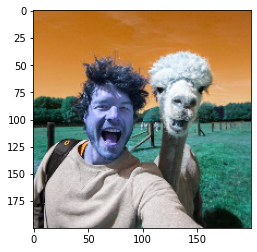

In [ ]:
#Читаем картинку
im_path = 'original.jpg'
im = cv.imread(im_path)
    
# размеры изображения
newH = 200  #высота
newW = int(im.shape[1]*200/im.shape[0]) # ширина 
#сжатая картинка
im = cv.resize(im, (newW, newH)) 
#Выводим 

plt.imshow(im)
plt.show()

Selective Search(селективный поиск)

In [ ]:
#Настройка модели
cv.setUseOptimized(True) #режим оптимизации
cv.setNumThreads(6)      #количество потоков

In [ ]:
# Объект Selective Search Segmentation
sss = cv.ximgproc.segmentation.createSelectiveSearchSegmentation()

# запускаем с картинкой
sss.setBaseImage(im)
  
# Выбираем точный метод 
sss.switchToSelectiveSearchQuality()

# Делаем selective search segmentation 
rects = sss.process() 
#вернёт массив прямоугольников, гдевозможно что-то есть
print(rects.shape) #число найденых объектов

(1640, 4)


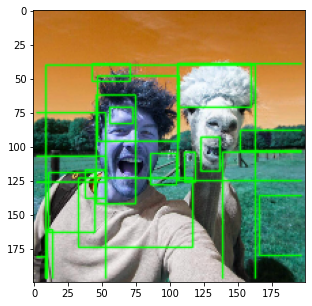

In [ ]:
#Построим области

num_Rects = 20 #число выводимых region proposals (прямоугольников)

#создаем копию исходной картинки
im_ = im.copy()

for i, rect in enumerate(rects): 
  if (i < num_Rects): #пока не больше 
    # x,y - координаты левого верхнего угла; w, h - ширина и высота области
    x, y, w, h = rect
    # рисуем рамку      
    cv.rectangle(im_, (x, y), (x+w, y+h), (0, 255, 0), 1, cv.LINE_AA) 
  else: 
    break 

# Рисуем на экран
plt.figure(figsize=(16,5))
plt.imshow(im_) 
plt.show()

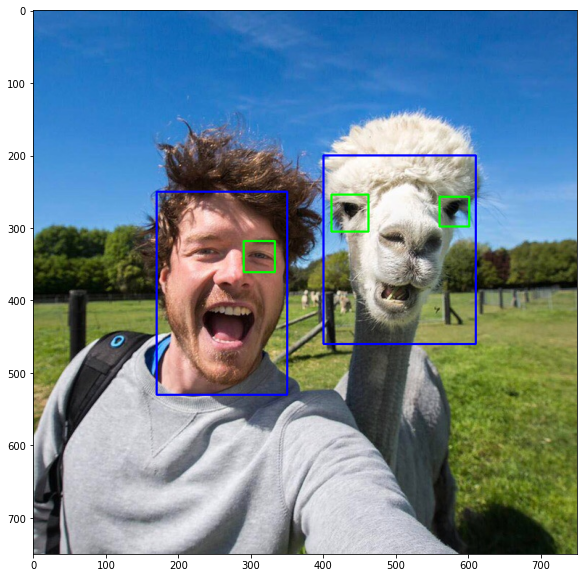

In [ ]:
imf = cv.imread(im_path)

#https://github.com/Itseez/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml
face_cascade = cv.CascadeClassifier('haarcascade_frontalface_default.xml')
#https://github.com/Itseez/opencv/blob/master/data/haarcascades/haarcascade_eye.xml
eye_cascade = cv.CascadeClassifier('haarcascade_eye.xml')


gray = cv.cvtColor(imf, cv.COLOR_RGB2GRAY)
#faces = face_cascade.detectMultiScale(gray, 1.3, 5)
#faces = [(300,50,160,200),(300,550,160,200)]
faces = [(170,250,180,280),(400,200,210,260)]

for (x,y,w,h) in faces:
        cv.rectangle(imf,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = imf[y:y+h, x:x+w]

        eyes = eye_cascade.detectMultiScale(roi_gray)
        for (ex,ey,ew,eh) in eyes:
            cv.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
plt.figure(figsize=(10,10))
plt.imshow(cv.cvtColor(imf,cv.COLOR_BGR2RGB))      
plt.show()   

## **Формирование и обработка результатов детектирования**

In [ ]:
# выводит картинку
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

#  Грузим и обрабатываем картинку
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpeg")
  response = urlopen(url)
  image_data = response.read()
  #read image
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  #print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

#  Рисуем рамку на изображении
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

#  Рисуем все рамки
# max_boxes - максимальное число объектов для отображения, min_score=0.01 - минимакльная точность их детекции
# можно менять

def draw_boxes(image, boxes, class_names, scores, max_boxes=3, min_score=0.01):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

# Практическое задание


### 1. Сделайте краткий обзор любой статьи посвященной тому или иному алгоритму для object detection. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?


<h3>Детекторы объектов на основе Transformer.</h3>

<p>Vision Transformer или ViT <a href="https://openreview.net/forum?id=YicbFdNTTy">(Dosovitskiy et al., 2021)</a> – это первая модель видения на основе трансформатора. Она обрабатывает изображение как последовательность патчей и использует оригинальный Transformer кодер для обработки данных изображения. Однако она может генерировать карту объектов только одного масштаба. Таким образом, она не может обнаруживать объекты различных масштабов (малых, средних или больших размеров).</p> 

<p>Модель DetTransNet принимает изображение в качестве входного сигнала. Затем она делит изображение на n перекрывающихся участков с m пикселями, перекрывающимися друг с другом. После этого патчи внедряются линейным слоем, выходы которого подаются на N трансформирующих слоёв. Затем все n перекрывающихся патчей реорганизуются в изображение. После нескольких блоков обработки получаются карты признаков. К карте признаков добавляется сеть предложений для обнаружения объектов. Классификатор используется для предсказания категории объекта по ограничивающим рамкам, в то время как блок регрессора используется для вывода координат ограничивающих границ рамки.</p>

<p>Transformer страдает от двух недостатков:</p>
<p> 1.	Во-первых, она требует гораздо больше времени на обучение, чем обычные детекторы на основе CNN.</p> 
<p> 2.	Во-вторых, она достигает низкой эффективности обнаружения мелких объектов.</p>

<p>Недостатки связаны из-за метода наложения и последовательности, при котором изображения делятся на участки, которые не содержат полезной информации о местоположении. В модели DetTransNet это решается за счёт использования перекрывающихся участков. Один контур разделяет m пикселей с соседними патчами. Изменяя число m, оно может обмениваться большей информацией с соседями. Это также может помочь в работе с небольшими участками выборки на картах признаков.</p>


<h3>Архитектура модели</h3>

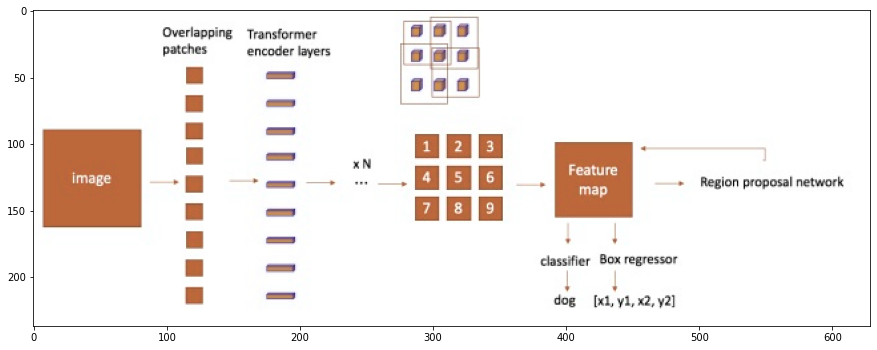

In [11]:
#Читаем картинку
im_path = 'Model.jpg'
im = cv.imread(im_path)
#Выводим 
plt.figure(figsize=(15,15))
plt.imshow(im)
plt.show()

<h3>Таблица результатов экспериментов на наборе данных COCO для обнаружения объектов.</h3>

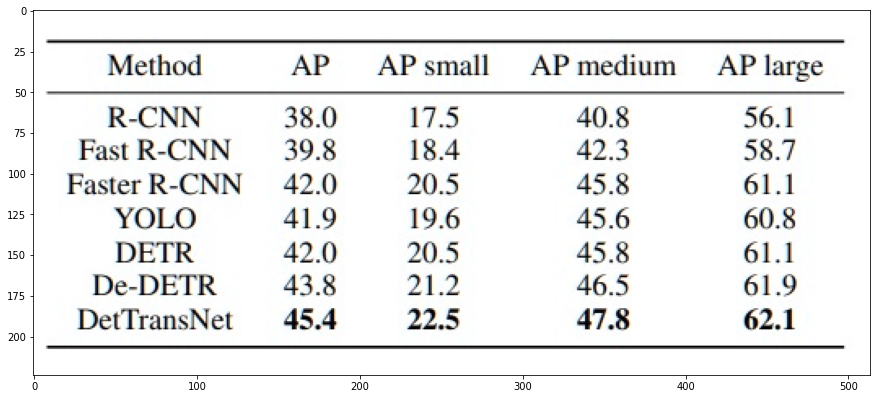

In [12]:
#Читаем картинку
im_path = 'table.jpg'
im = cv.imread(im_path)
#Выводим 
plt.figure(figsize=(15,15))
plt.imshow(im)
plt.show()

Ссылка на статью: <a href="https://arxiv.org/pdf/2206.06323.pdf">https://arxiv.org/pdf/2206.06323.pdf</a>

### 2. Запустим детектор (ssdMobile_v2 или faster_rcnn, или любой другой детектор) для своей картинки и попробуем найти 10 объектов, 100 объектов.

In [ ]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


### Обработка изображения для передачи в детектор:

Формируем тензор

In [ ]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

Выполняем детектор

In [ ]:
def run_detector(detector, path,  max_boxes=20, min_score=0.01):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()
  #print(result['detection_scores'])
  result = {key:value.numpy() for key,value in result.items()} 

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=max_boxes, min_score=min_score)

  display_image(image_with_boxes)
  return result

Чтение имен кадров 

In [ ]:
import os, fnmatch
root_path = './'
listOfFiles = os.listdir(root_path)
pattern = 'kozirki.jpg'
List_name=[]
for entry in listOfFiles:
    if fnmatch.fnmatch(entry, pattern):
            List_name.append(np.array(root_path+entry))
List_name[0]


array('./kozirki.jpg', dtype='<U13')

Проверяем детектор

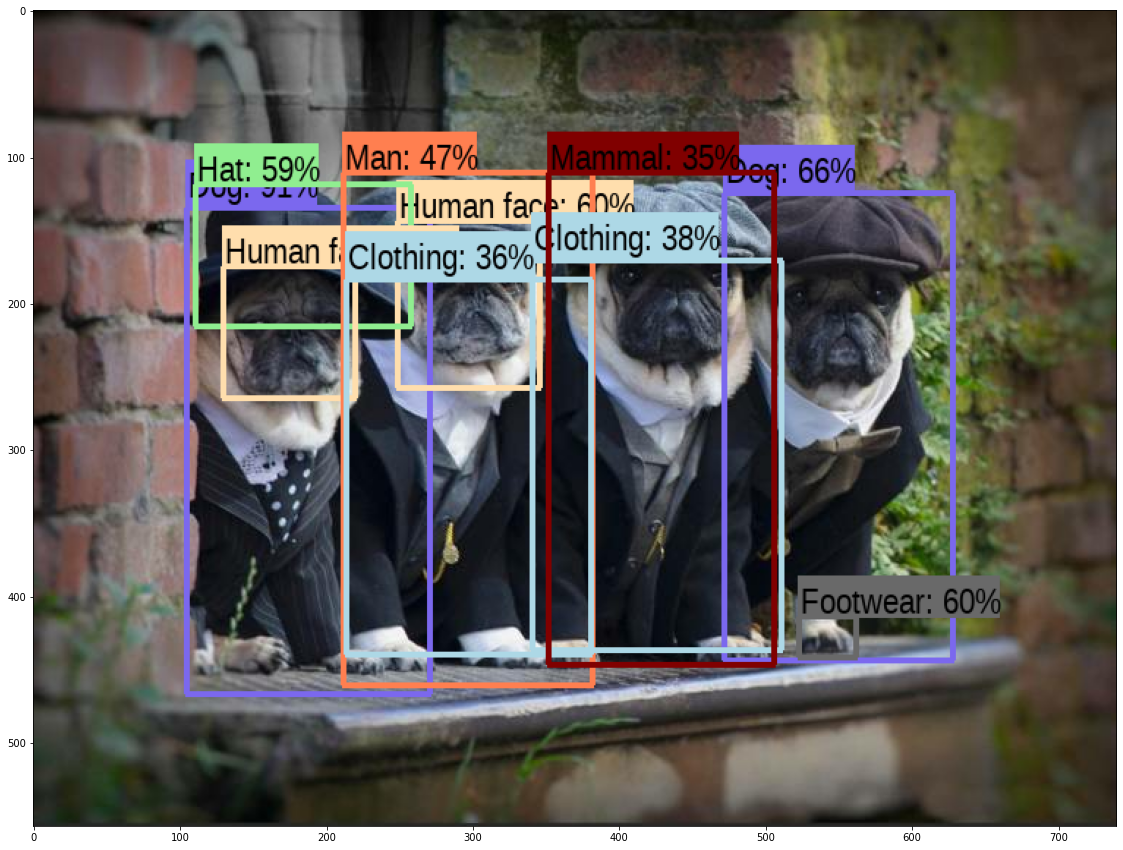

In [ ]:
result = run_detector(detector, List_name[0], max_boxes=10, min_score=0.20)

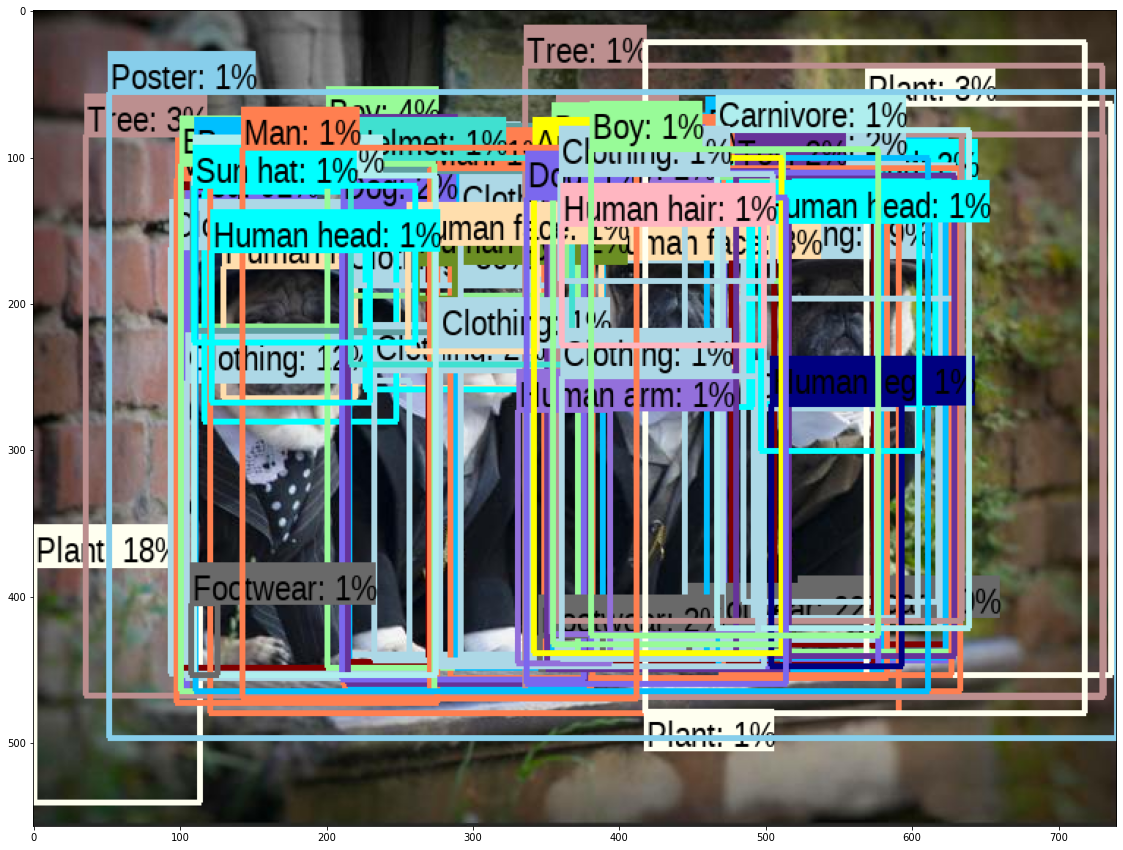

In [ ]:
result = run_detector(detector, List_name[0], max_boxes=100, min_score=0.01)